In [1]:
#Importing Libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, math, sys, glob
import seaborn as sn
from PIL import Image
from pathlib import Path
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import *
from torch.utils.data import Dataset
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import save_image, make_grid
from torchvision.transforms import ToTensor
from torchvision.models import vgg19
import torchvision.transforms.functional as TF
from sklearn.metrics import confusion_matrix
from torchsummary import summary
from torch.autograd import Variable
import torch.optim as optim


import warnings
warnings.filterwarnings("ignore")

In [2]:

#Dataset
!wget "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip"
!wget "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip"
!wget "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip"
!wget "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X2.zip"

--2023-12-07 00:55:53--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip [following]
--2023-12-07 00:55:53--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448993893 (428M) [application/zip]
Saving to: ‘DIV2K_valid_HR.zip’

DIV2K_valid_HR.zip  100%[===================>] 428.19M  19.6MB/s    in 23s     

2023-12-07 00:56:17 (18.7 MB/s) - ‘DIV2K_valid_HR.zip’ saved [448993893/448993893]

--2023-12-07 00:56:17--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (d

In [3]:
#Unzipping the downloaded data files
!unzip DIV2K_train_LR_bicubic_X2.zip
!unzip DIV2K_valid_HR
!unzip DIV2K_valid_LR_bicubic_X2.zip
!unzip DIV2K_train_HR.zip

Archive:  DIV2K_train_LR_bicubic_X2.zip
   creating: DIV2K_train_LR_bicubic/X2/
  inflating: DIV2K_train_LR_bicubic/X2/0261x2.png  
  inflating: DIV2K_train_LR_bicubic/X2/0229x2.png  
  inflating: DIV2K_train_LR_bicubic/X2/0188x2.png  
  inflating: DIV2K_train_LR_bicubic/X2/0711x2.png  
  inflating: DIV2K_train_LR_bicubic/X2/0187x2.png  
  inflating: DIV2K_train_LR_bicubic/X2/0198x2.png  
  inflating: DIV2K_train_LR_bicubic/X2/0770x2.png  
  inflating: DIV2K_train_LR_bicubic/X2/0694x2.png  
  inflating: DIV2K_train_LR_bicubic/X2/0001x2.png  
  inflating: DIV2K_train_LR_bicubic/X2/0414x2.png  
  inflating: DIV2K_train_LR_bicubic/X2/0123x2.png  
  inflating: DIV2K_train_LR_bicubic/X2/0067x2.png  
  inflating: DIV2K_train_LR_bicubic/X2/0538x2.png  
  inflating: DIV2K_train_LR_bicubic/X2/0178x2.png  
  inflating: DIV2K_train_LR_bicubic/X2/0587x2.png  
  inflating: DIV2K_train_LR_bicubic/X2/0357x2.png  
  inflating: DIV2K_train_LR_bicubic/X2/0598x2.png  
  inflating: DIV2K_train_LR_bicubic/

In [4]:
#Directories
traindataset_hr_dir = "./DIV2K_train_HR"
traindataset_lr_dir = "./DIV2K_train_LR_bicubic/X2"
testdataset_hr_dir = "./DIV2K_valid_HR"
testdataset_lr_dir = "./DIV2K_valid_LR_bicubic/X2"

In [5]:
#Setting input_size for training
lr_input_size = 100
upscale = 2
hr_input_size = (upscale**2) * lr_input_size

#Transform without rotation for visualization
hr_transform = transforms.Compose([
	transforms.CenterCrop(hr_input_size),
	transforms.ToTensor()
])
lr_transform = transforms.Compose([
	transforms.CenterCrop(lr_input_size),
	transforms.ToTensor()
])


In [6]:
#Defining DIV2K class to access all the images from folders
class SR_DIV2K_Dataset(Dataset):
	def __init__(self, data_dir, transform=transforms.ToTensor()):
		# Getting all paths of images inside image directory into a list using glob pattern
		pattern = os.path.join(data_dir, "**/*.png")
		self.file_paths = sorted(glob.glob(pattern, recursive=True))
		self.transform = transform

	def __len__(self):
		return len(self.file_paths)

	def __getitem__(self, index):
		file_name = self.file_paths[index].split('/')[-1]
		img = Image.open(self.file_paths[index])
		img = self.transform(img)
		return img, file_name

data_train_hr = SR_DIV2K_Dataset(data_dir=os.path.join("./", traindataset_hr_dir), transform=hr_transform)
data_train_lr = SR_DIV2K_Dataset(data_dir=os.path.join("./", traindataset_lr_dir), transform=lr_transform)

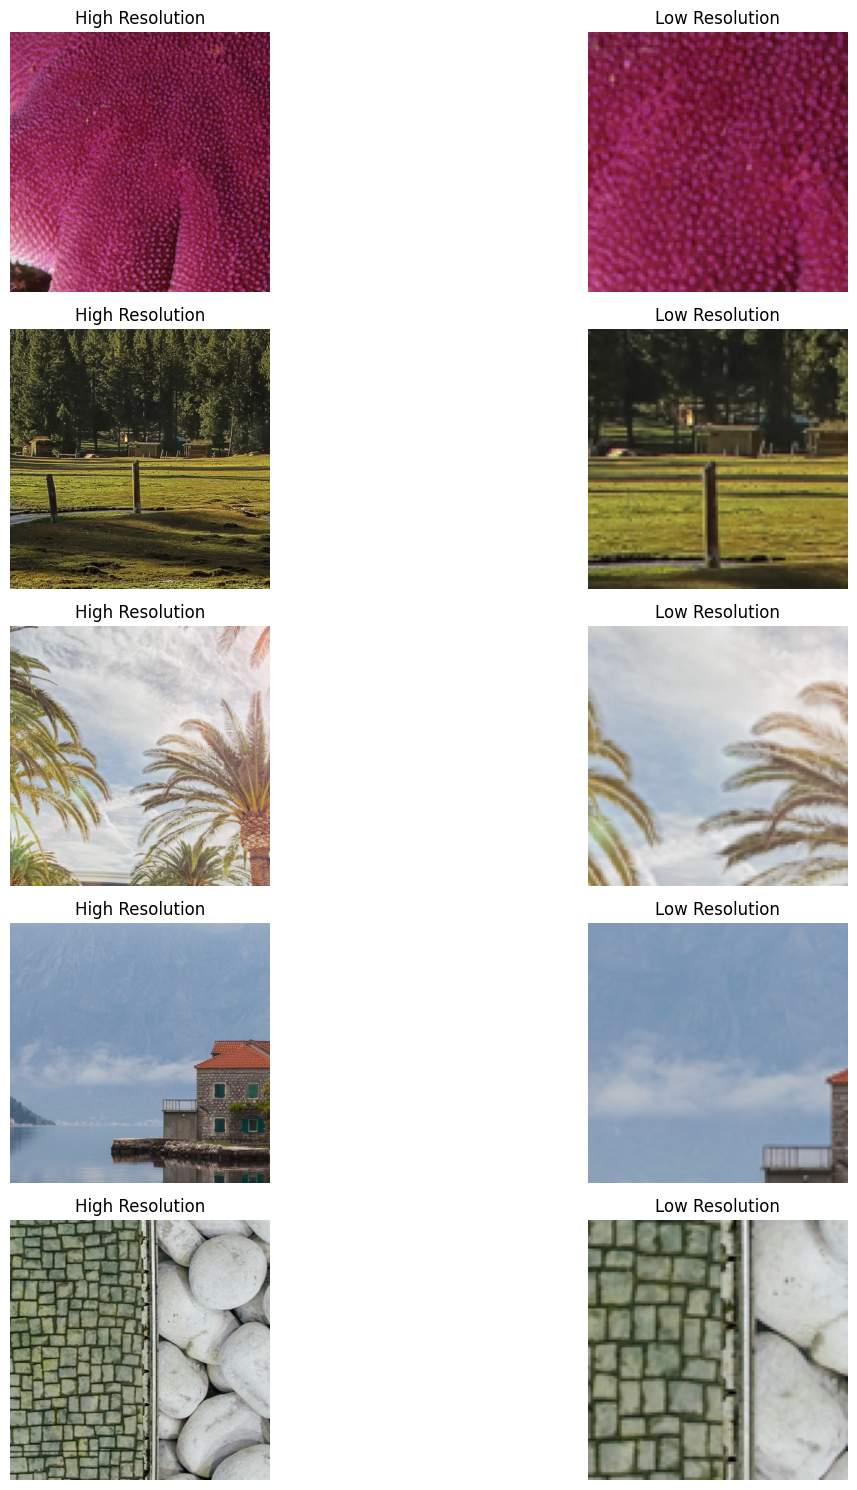

In [7]:
num_images_to_display = 5

# Subplots
fig, axes = plt.subplots(num_images_to_display, 2, figsize=(15, 15))

for i in range(num_images_to_display):

    hr_img, _ = data_train_hr[i]
    lr_img, _ = data_train_lr[i]

    # Converting tensors to PIL images for visualization
    hr_img_pil = TF.to_pil_image(hr_img)
    lr_img_pil = TF.to_pil_image(lr_img)

    # LR image
    axes[i, 1].imshow(lr_img_pil)
    axes[i, 1].set_title("Low Resolution")

    # HR image
    axes[i, 0].imshow(hr_img_pil)
    axes[i, 0].set_title("High Resolution")

    axes[i, 0].axis("off")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [8]:
# Data augmentation transforms with rotation and without flipping for training purposes
hr_transform = transforms.Compose([
    transforms.CenterCrop(hr_input_size),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor()
])

lr_transform = transforms.Compose([
    transforms.CenterCrop(lr_input_size),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor()
])

data_train_hr = SR_DIV2K_Dataset(data_dir=os.path.join("./", traindataset_hr_dir), transform=hr_transform)
data_train_lr = SR_DIV2K_Dataset(data_dir=os.path.join("./", traindataset_lr_dir), transform=lr_transform)

In [9]:
#Defining a Generator Class
class SRGenerator(nn.Module):
	def __init__(self, num_res_blocks, upscale_factor=2):
		super(SRGenerator, self).__init__()

		#Convolutional layer
		self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, padding=4)
		self.prelu1 = nn.PReLU()

		#Residual Block
		self.res_blocks = nn.Sequential()
		for i in range(num_res_blocks):
			self.res_blocks.add_module(f"res_blk_{i}",
									   Residual_Block(in_channels=64, out_channels=64,strides=1, use_1x1_conv=False))
		self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
		self.batch_norm = nn.BatchNorm2d(64)

		#Pixel Shufflers
		self.pixel_shuffler1 = nn.Sequential(
			nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1),
			nn.PixelShuffle(upscale_factor=upscale_factor),
			nn.PReLU()
		)
		self.pixel_shuffler2 = nn.Sequential(
			nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1),
			nn.PixelShuffle(upscale_factor=upscale_factor),
			nn.PReLU()
		)
		self.conv3 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=9, padding=4)

	#Generator model flow
	def forward(self, X):
		X = self.prelu1(self.conv1(X))
		X_before_resblocks = X.clone()

		X = self.res_blocks(X)
		X = self.batch_norm(self.conv2(X))

		#Element Wise Sum (Skip Connection)
		X = F.relu(X + X_before_resblocks)
		X = self.pixel_shuffler1(X)
		X = self.pixel_shuffler2(X)

		X = self.conv3(X)

		return F.tanh(X)

#Residual Block Class
class Residual_Block(nn.Module):
	def __init__(self, in_channels, out_channels, strides, use_1x1_conv=True):
		super(Residual_Block, self).__init__()

		self.use_1x1_conv = use_1x1_conv
		self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides)
		self.convBlock = nn.Sequential(
			nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=strides, padding=1),
			nn.BatchNorm2d(out_channels),
			nn.PReLU(),
			nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
			nn.BatchNorm2d(out_channels),
		)


	def forward(self, X):

		X_original = X.clone()
		X = self.convBlock(X)
		if self.use_1x1_conv:
			X_original = self.conv1x1(X_original)
		#Element wise sum (Skip Connection)
		return F.relu(X + X_original)


In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.2)
        )

        # Convolutional Blocks
        self.conv_blks = nn.Sequential(
            ConvBlock(64, 64, 2),
            ConvBlock(64, 128, 1),
            ConvBlock(128, 128, 2),
            ConvBlock(128, 256, 1),
            ConvBlock(256, 256, 2),
            ConvBlock(256, 512, 1),
            ConvBlock(512, 512, 2)
        )

        self.global_pooling = nn.AdaptiveAvgPool2d(output_size=1)
        # self.conv2 = nn.Sequential(
        #     nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1),
        #     nn.LeakyReLU(negative_slope=0.2)
        # )

        self.fc1 = nn.Sequential(
              nn.Linear(512, 1024),
              nn.LeakyReLU(negative_slope=0.2)
          )

        self.fc2 = nn.Linear(1024, 1)
        self.LeakyReLU = nn.LeakyReLU(negative_slope = 0.2)

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv_blks(X)
        X = self.global_pooling(X)
        X = X.flatten(start_dim=1)
        X = self.LeakyReLU(self.fc1(X))
        X = self.fc2(X)
        return torch.sigmoid(X)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, strides=1):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=strides, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.2)
        )

    def forward(self, X):
        return self.block(X)


In [11]:
learning_rate = 0.001
betas = (0.9, 0.9999)

vgg_loss_coef = 0.006
adversarial_loss_coef = 0.001

#Defining class to calculate perceptual loss, adverserial loss and vgg loss
class PerceptualLoss(nn.Module):
	def __init__(self, vgg_coef, adversarial_coef):
		super(PerceptualLoss, self).__init__()
		_vgg19 = vgg19(pretrained=True)
		self.vgg19 = nn.Sequential(*_vgg19.features).eval()
		for p in self.vgg19.parameters():
			p.requires_grad = False
		self.euclidean_distance = nn.MSELoss()
		self.vgg_coef = vgg_coef
		self.adversarial_coef = adversarial_coef

	def forward(self, sr_img, hr_img, output_labels):
		adversarial_loss = torch.mean(1-output_labels)
		vgg_loss = self.euclidean_distance(self.vgg19(sr_img), self.vgg19(hr_img))
		pixel_loss = self.euclidean_distance(sr_img, hr_img)
		return pixel_loss, self.adversarial_coef*adversarial_loss, self.vgg_coef*vgg_loss

In [12]:
#Paths to store model state for the Generator and Discriminator so that the training can be continued from last epoch even if stopped
stored_model_path_for_gen = Path("./model/G.pt")
stored_model_path_for_dis = Path("./model/D.pt")

def saving_modelstate(G, D, optimizer_G, optimizer_D, epoch):
	checkpoint_G = {
		'model': G,
		'state_dict': G.state_dict(),
		'optimizer': optimizer_G.state_dict(),
		'epoch': epoch
	}
	checkpoint_D = {
		'model': D,
		'state_dict': D.state_dict(),
		'optimizer': optimizer_D.state_dict(),
	}
	torch.save(checkpoint_G, stored_model_path_for_gen)
	torch.save(checkpoint_D, stored_model_path_for_dis)

def loading_modelstate(G, D, optimizerG, optimizerD):
	print("Loading model state")
	checkpoint_G = torch.load(stored_model_path_for_gen)
	checkpoint_D = torch.load(stored_model_path_for_dis)
	G.load_state_dict(checkpoint_G['state_dict'])
	optimizerG.load_state_dict(checkpoint_G['optimizer'])
	D.load_state_dict(checkpoint_D['state_dict'])
	optimizerD.load_state_dict(checkpoint_D['optimizer'])
	prev_epochs = checkpoint_G['epoch']
	print("Loaded model state successfully!")
	return G, D, optimizerG, optimizerD, prev_epochs

In [13]:
def kaiming_init_weights(model):
    if isinstance(model, torch.nn.Linear):
        torch.nn.init.kaiming_uniform_(model.weight)
    elif isinstance(model, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(model.weight)

device: CUDA
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 100, 100]          15,616
             PReLU-2          [8, 64, 100, 100]               1
            Conv2d-3          [8, 64, 100, 100]          36,928
       BatchNorm2d-4          [8, 64, 100, 100]             128
             PReLU-5          [8, 64, 100, 100]               1
            Conv2d-6          [8, 64, 100, 100]          36,928
       BatchNorm2d-7          [8, 64, 100, 100]             128
    Residual_Block-8          [8, 64, 100, 100]               0
            Conv2d-9          [8, 64, 100, 100]          36,928
      BatchNorm2d-10          [8, 64, 100, 100]             128
            PReLU-11          [8, 64, 100, 100]               1
           Conv2d-12          [8, 64, 100, 100]          36,928
      BatchNorm2d-13          [8, 64, 100, 100]             128
   Residual_Block-14      

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 68.6MB/s]



Epoch: 1
	Batch: 1/100
	err_D_real: 0.3340; err_D_fake: 1.3199;  err_G: 0.5791; D_x: 0.7253; D_Gz1: 0.7307; D_Gz2: 0.1204
	 adversarial_loss: 0.0009, vgg_loss: 0.0013, pixel_loss: 0.5768
	Batch: 11/100
	err_D_real: 0.4860; err_D_fake: 0.9513;  err_G: 0.1124; D_x: 0.6457; D_Gz1: 0.5912; D_Gz2: 0.4185
	 adversarial_loss: 0.0006, vgg_loss: 0.0020, pixel_loss: 0.1098
	Batch: 21/100
	err_D_real: 0.2818; err_D_fake: 0.1316;  err_G: 0.0903; D_x: 0.7795; D_Gz1: 0.1201; D_Gz2: 0.1480
	 adversarial_loss: 0.0009, vgg_loss: 0.0014, pixel_loss: 0.0880
	Batch: 31/100
	err_D_real: 0.2142; err_D_fake: 0.1430;  err_G: 0.0737; D_x: 0.8553; D_Gz1: 0.1323; D_Gz2: 0.0817
	 adversarial_loss: 0.0009, vgg_loss: 0.0026, pixel_loss: 0.0702
	Batch: 41/100
	err_D_real: 0.0597; err_D_fake: 0.1943;  err_G: 0.0542; D_x: 0.9858; D_Gz1: 0.1700; D_Gz2: 0.1007
	 adversarial_loss: 0.0009, vgg_loss: 0.0016, pixel_loss: 0.0517
	Batch: 51/100
	err_D_real: 0.1058; err_D_fake: 0.0433;  err_G: 0.0582; D_x: 0.9244; D_Gz1: 0.04

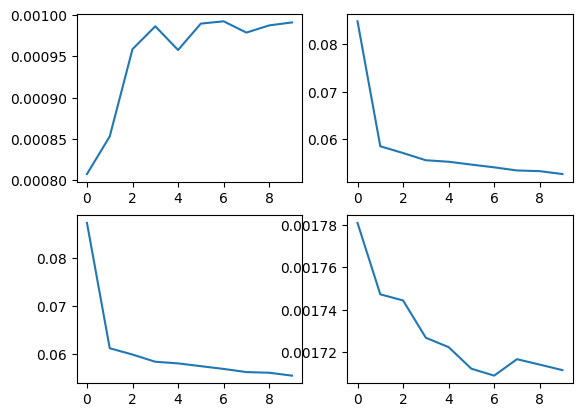


Epoch: 11
	Batch: 1/100
	err_D_real: 0.0630; err_D_fake: 0.0000;  err_G: 0.0400; D_x: 0.9970; D_Gz1: 0.0000; D_Gz2: 0.0000
	 adversarial_loss: 0.0010, vgg_loss: 0.0011, pixel_loss: 0.0379
	Batch: 11/100
	err_D_real: 0.0568; err_D_fake: 0.0000;  err_G: 0.0539; D_x: 0.9911; D_Gz1: 0.0000; D_Gz2: 0.0001
	 adversarial_loss: 0.0010, vgg_loss: 0.0018, pixel_loss: 0.0511
	Batch: 21/100
	err_D_real: 0.0598; err_D_fake: 0.0122;  err_G: 0.0624; D_x: 0.9924; D_Gz1: 0.0118; D_Gz2: 0.0783
	 adversarial_loss: 0.0009, vgg_loss: 0.0014, pixel_loss: 0.0600
	Batch: 31/100
	err_D_real: 0.0605; err_D_fake: 0.1730;  err_G: 0.0581; D_x: 0.9959; D_Gz1: 0.1453; D_Gz2: 0.1256
	 adversarial_loss: 0.0009, vgg_loss: 0.0025, pixel_loss: 0.0547
	Batch: 41/100
	err_D_real: 0.0641; err_D_fake: 0.0012;  err_G: 0.0431; D_x: 0.9977; D_Gz1: 0.0012; D_Gz2: 0.0019
	 adversarial_loss: 0.0010, vgg_loss: 0.0015, pixel_loss: 0.0405
	Batch: 51/100
	err_D_real: 0.0608; err_D_fake: 0.0011;  err_G: 0.0482; D_x: 0.9924; D_Gz1: 0.0

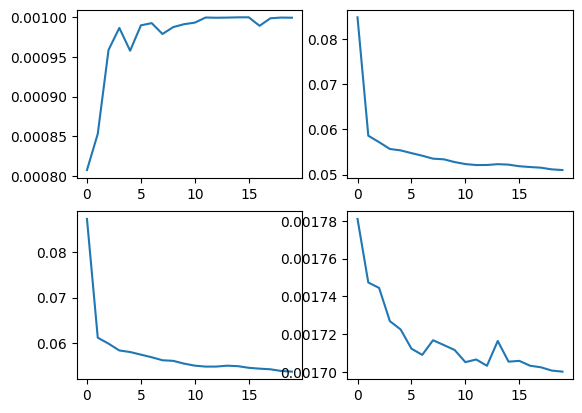

In [15]:
# Training
real_value = 0.99
fake_value = 0.0

batch_size = 8
epochs = 20

n_resblock = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {str(device).upper()}")

def train(resume_training=True):
    # Loading the data
    hr_train_loader = DataLoader(dataset=data_train_hr, shuffle=False, batch_size=batch_size, drop_last=False)
    lr_train_loader = DataLoader(dataset=data_train_lr, shuffle=False, batch_size=batch_size, drop_last=False)
    # Error checking for the number of images to be the same in both LR and HR folders
    assert len(hr_train_loader) == len(lr_train_loader)

    # Loading the models
    G = SRGenerator(num_res_blocks=n_resblock, upscale_factor=upscale).to(device)
    D = Discriminator().to(device)
    optimizer_G = optim.Adam(G.parameters(), lr=learning_rate, betas=betas)
    optimizer_D = optim.Adam(D.parameters(), lr=learning_rate, betas=betas)

    # Save model state
    if resume_training and stored_model_path_for_gen.exists() and stored_model_path_for_dis.exists():
        G, D, optimizer_G, optimizer_D, prev_epochs = loading_modelstate(G, D, optimizer_G, optimizer_D)
        print("Continuing training from the previous epoch by loading the previous state")
    else:
        G.apply(kaiming_init_weights)
        D.apply(kaiming_init_weights)
        prev_epochs = 0
        summary(G, input_size=(3, lr_input_size, lr_input_size), batch_size=batch_size, device=str(device))
        summary(D, input_size=(3, hr_input_size, hr_input_size), batch_size=batch_size, device=str(device))
        print("Training")

    # Training
    G.train()
    D.train()

    # Loss functions
    criterion_G = PerceptualLoss(vgg_coef=vgg_loss_coef, adversarial_coef=adversarial_loss_coef).to(device)
    criterion_D = torch.nn.BCELoss()
    epoch_pixel_loss = []
    epoch_adversial_loss = []
    epoch_vgg_loss = []
    epoch_error_G = []

    # Epochs
    for epoch in range(epochs):
        batch_adversarial_loss = 0
        batch_pixel_loss = 0
        batch_vgg_loss = 0
        batch_error_G = 0
        print(f"\nEpoch: {epoch + prev_epochs + 1}")
        n_batches = 0
        for (batch, hr_batch), lr_batch in zip(enumerate(hr_train_loader), lr_train_loader):
            n_batches += 1
            # Transfer data to GPU if available
            hr_img, lr_img = hr_batch[0].to(device), lr_batch[0].to(device)

            # Training Discriminator to maximize log(D(x)) + log(1-D(G(z)))
            optimizer_D.zero_grad()

            # Classify all-real HR images
            real_labels = torch.full(size=(len(hr_img),), fill_value=real_value, dtype=torch.float, device=device)
            output_real = D(hr_img).view(-1)
            err_D_real = criterion_D(output_real, real_labels)
            err_D_real.backward()

            # Classify all-fake HR images (or SR images) before the generator update
            fake_labels = torch.full(size=(len(hr_img),), fill_value=fake_value, dtype=torch.float, device=device)
            sr_img_before_update = G(lr_img)
            output_fake_before_update = D(sr_img_before_update.detach()).view(-1)
            err_D_fake = criterion_D(output_fake_before_update, fake_labels)
            err_D_fake.backward()
            optimizer_D.step()
            D_Gz1 = output_fake_before_update.mean().item()
            del sr_img_before_update, output_fake_before_update

            # for _ in range(1):
            #     optimizer_G.zero_grad()
            #     gen = G(lr_img)
            #     pixel_loss, adversarial_loss, vgg_loss = criterion_G(gen, hr_img, D(gen).view(-1))
            #     err_G = pixel_loss + adversarial_loss + vgg_loss
            #     err_G.backward(retain_graph=True)
            #     optimizer_G.step()
            #     del pixel_loss, adversarial_loss, vgg_loss

            # Training Generator to minimize log(D(G(z))
            optimizer_G.zero_grad()
            output_fake_after_update = D(G(lr_img)).view(-1)
            pixel_loss, adversarial_loss, vgg_loss = criterion_G(G(lr_img), hr_img, output_fake_after_update)
            err_G = pixel_loss + adversarial_loss + vgg_loss
            err_G.backward()
            optimizer_G.step()

            batch_adversarial_loss += adversarial_loss.item()
            batch_pixel_loss += pixel_loss.item()
            batch_vgg_loss += vgg_loss.item()
            batch_error_G += err_G.item()
            # Print stats
            if batch % 10 == 0:
                print(f"\tBatch: {batch + 1}/{len(data_train_hr) // batch_size}")
                D_x = output_real.mean().item()
                # Classify all-fake HR images (or SR images) after the generator update
                output_fake_after_update = D(G(lr_img)).view(-1)
                D_Gz2 = output_fake_after_update.mean().item()

                print(f"\terr_D_real: {err_D_real.item():.4f}; err_D_fake: {err_D_fake.item():.4f}; "
                      f" err_G: {err_G.item():.4f}; D_x: {D_x:.4f}; D_Gz1: {D_Gz1:.4f}; D_Gz2: {D_Gz2:.4f}")
                print(f"\t adversarial_loss: {adversarial_loss:.4f}, vgg_loss: {vgg_loss:.4f}, "
                      f"pixel_loss: {pixel_loss:.4f}")
            # Clearing variable data to free up GPU memory
            del hr_img, lr_img, err_D_fake, err_D_real, err_G, real_labels, fake_labels, output_real, output_fake_after_update, pixel_loss, adversarial_loss, vgg_loss
            torch.cuda.empty_cache()
        epoch_adversial_loss.append(batch_adversarial_loss / n_batches)
        epoch_pixel_loss.append(batch_pixel_loss / n_batches)
        epoch_error_G.append(batch_error_G / n_batches)
        epoch_vgg_loss.append(batch_vgg_loss / n_batches)
        n_batches = 0
        # Save model state
        saving_modelstate(G, D, optimizer_G, optimizer_D, epoch=prev_epochs + epoch + 1)
        # Plot the graph after every 10 epochs
        if (epoch + 1) % 10 == 0:
          plt.subplot(2, 2, 1)
          plt.plot(epoch_adversial_loss)
          plt.subplot(2, 2, 2)
          plt.plot(epoch_pixel_loss)
          plt.subplot(2, 2, 3)
          plt.plot(epoch_error_G)
          plt.subplot(2, 2, 4)
          plt.plot(epoch_vgg_loss)
          plt.show()


if __name__ == "__main__":
    torch.autograd.set_detect_anomaly(True)
    train()


In [ ]:
# Defining the 'sr_img' folder
SR_DIR = "./sr_img"
os.makedirs(SR_DIR, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to generate super-resolution images
def generate_sr(lr_img_path):
    with torch.no_grad():
        pil_img = Image.open(lr_img_path)
        img_tensor = transforms.ToTensor()(pil_img)
        img_tensor = torch.unsqueeze(img_tensor, 0)  # add batch dimension
        img_tensor = img_tensor.to(device)
        sr_img = G(img_tensor)
        print(f"Upscaled from size [{img_tensor.shape[2]}, {img_tensor.shape[3]}] to [{sr_img.shape[2]}, {sr_img.shape[3]}]")

    file_name = os.path.basename(lr_img_path)
    sr_img_path = os.path.join(SR_DIR, f"sr_{file_name}")
    tensor_to_img(sr_img, sr_img_path)

def tensor_to_img(tensor, filepath):
    tensor = tensor.cpu()
    tensor_pil = transforms.ToPILImage()(tensor.squeeze_(0))
    tensor_pil.save(filepath)
    print(f"Saved to {filepath}")

# Loading the stored model state for generator testing
G = SRGenerator(num_res_blocks=n_resblock, upscale_factor=upscale)
if stored_model_path_for_gen.exists():
    checkpoint_G = torch.load(stored_model_path_for_gen)
    G.load_state_dict(checkpoint_G['state_dict'])
    G.to(device)
else:
    print("Model state not present, using Kaiming He initialization as parameters.")
    G.apply(kaiming_init_weights).to(device)
G.eval()

# Test the SRGAN model on all test LR samples
test_lr_images_dir = './DIV2K_valid_LR_bicubic/X2/'  # Change this to your test LR images directory

# Get a list of all LR images in the test set
lr_image_files = os.listdir(test_lr_images_dir)

# Loop through all LR images and generate super-resolution images
for lr_image_file in lr_image_files:
    lr_img_path = os.path.join(test_lr_images_dir, lr_image_file)
    generate_sr(lr_img_path)


In [ ]:
from google.colab import files
files.download('sr_img')